# Image segmentation with a U-Net-like architecture

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2019/03/20<br>
**Last modified:** 2020/04/20<br>
**Description:** Image segmentation model trained from scratch on the Oxford Pets dataset.

- Keras document : https://keras.io/examples/vision/oxford_pets_image_segmentation/


- Unet paper : https://arxiv.org/abs/1505.04597
- Unet code : https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py
- Unet explanation : https://towardsdatascience.com/u-net-b229b32b4a71


- Xception paper : https://arxiv.org/abs/1610.02357
- 'SeparableConv2d' torch code referecne : https://ysbsb.github.io/cnn/2020/02/20/Xception.html

## Download the data

In [1]:
# !curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
# !curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
# !tar -xf images.tar.gz
# !tar -xf annotations.tar.gz

## Prepare paths of input images and target segmentation masks

```
1. [커널이 잡고 있는 memory 초기화] - 형원
for pid in $(ps -ef | grep -v "awk" | awk '/ipykernel_launcher/ {print $2}'); do sudo kill -9 $pid; done

2. batch size - 재혁
batch_size 4 -> 32 조정 후 성능 확인 필요
```

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import numpy as np
from torchvision.io import read_image

import os

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 32
device = "cuda:0" if torch.cuda.is_available() else "cpu"

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


In [3]:
# 개별 이미지 샘플의 shape이 모두 다름
import cv2
for i in range(10, 20):
    img = cv2.imread(input_img_paths[i])
    print(f"i : {i} | shape : {img.shape}")

i : 10 | shape : (404, 500, 3)
i : 11 | shape : (450, 282, 3)
i : 12 | shape : (288, 192, 3)
i : 13 | shape : (319, 400, 3)
i : 14 | shape : (402, 500, 3)
i : 15 | shape : (500, 490, 3)
i : 16 | shape : (425, 640, 3)
i : 17 | shape : (423, 640, 3)
i : 18 | shape : (367, 500, 3)
i : 19 | shape : (500, 333, 3)


## What does one input image and corresponding segmentation mask look like?

**supplement**
- ```PIL.ImageOps.autocontrast```
    - pillow official docs : https://pillow.readthedocs.io/en/stable/reference/ImageOps.html

In [4]:
# def load_imgs(f_name, target_size=None, color_mode=None):
#     img = cv2.imread(f_name)
    
#     if target_size is not None:
#         img = acv2.resize(img, target_size)
    
#     # change rgb to bgr
#     img = img[...,::-1]
    
#     if color_mode == 'grayscale':
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
#     return img

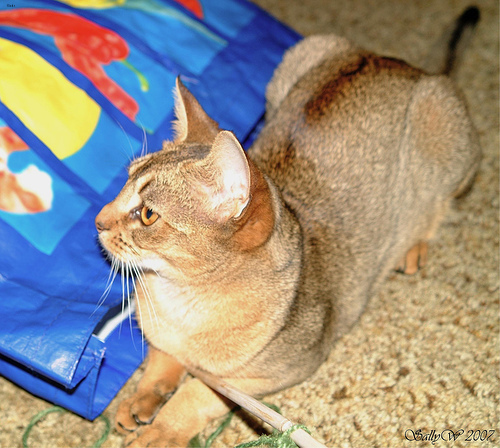

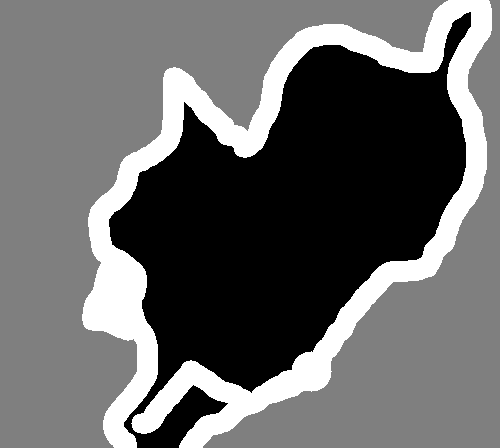

In [5]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

## Prepare `Sequence` class to load & vectorize batches of data

In [6]:
class OxfordPets(Dataset):
    
    def __init__(self, img_size, input_img_paths, target_img_paths):
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        
    def __len__(self):
        return len(self.target_img_paths)
    
    def __getitem__(self, idx):
        '''
        Returns tuple(input, target) correspond to batch #idx.
        '''
        input_img_paths = self.input_img_paths[idx]
        target_img_paths = self.target_img_paths[idx]
        
        x = np.zeros((3,) + self.img_size, dtype="float32") # |x| = (3, 160, 160)
        for path in [input_img_paths]:
            img = load_img(path, target_size=self.img_size) # |img| = (160, 160, 3)
            x = img
            
            
        y = np.zeros((1,) + self.img_size, dtype="uint8") # |y| = (1, 160, 160), image resize
        for path in [target_img_paths]:
            img = load_img(path, target_size=self.img_size, color_mode="grayscale") # |img| = (160, 160)
            y = np.expand_dims(img, 0) # |y| = (1,160,160)
            
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y_subtracted = np.copy(y)
            y_subtracted -= 1
            
        x, y = np.asarray(x), np.asarray(y_subtracted)
        x = np.swapaxes(x,0,2)
            
        x_transformed = torch.from_numpy(x)        
        y_transformed = torch.from_numpy(y)

        return x_transformed, y_transformed

## Set aside a validation split

In [7]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

In [8]:
print(f"Nums of train images : {len(train_input_img_paths)}")
print(f"Nums of val images : {len(val_input_img_paths)}")

Nums of train images : 6390
Nums of val images : 1000


**Define dataset**

In [9]:
# Instantiate data Sequences for each split
train_gen = OxfordPets(
    img_size, 
    train_input_img_paths, 
    train_target_img_paths,
)

val_gen = OxfordPets(
    img_size,
    val_input_img_paths, 
    val_target_img_paths,
)

**Define DataLoader**

In [10]:
train_dataloader = DataLoader(train_gen, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_gen, batch_size=batch_size, shuffle=True)

## Prepare U-Net Xception-style model

### U-Net Xception-style

- **Down | Up sampling + Depthwise Separable Convolution 사용**

    - U-Net
        - Encoder(Down sampling, conv), Decoder(Up sampling, Transconv)

    - Xception
        - Depthwise Separable Convolution 사용
        
        <img src = "depthwise_conv.png" width="80%" height="80%">
        


**보충**

- Depthwise convolution(SeparableConv2D)
    - **Depthwise conv**(각 채널 별 독립적인 pattern) + **Pointwise conv**(채널 간 pattern)
        - ref : https://www.python2.net/questions-972522.htm
        - ref : https://zzsza.github.io/data/2018/02/23/introduction-convolution/
        - ref : https://www.youtube.com/watch?v=V0dLhyg5_Dw
        - ref : https://hichoe95.tistory.com/48
        
- transposedConv2d vs deconvolution
    - Transposed Conv 2D : 원본의 size 복원
    - Deconv 2D : 원본의 input 복원
    - ref : https://velog.io/@hayaseleu/Transposed-Convolutional-Layer은-무엇인가
    


- Loss.backward() 할 때 inplace modification Error 
    - debugging ref : https://daeheepark.tistory.com/24

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F        


class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1):
        super(SeparableConv2d, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels, in_channels, kernel_size, stride, padding, dilation, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, 1, 0, 1, 1, bias=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x

    
class Down_DoubleConv(nn.Module):
    """(ReLU => [BN] => convolution) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.down_double_conv = nn.Sequential(
            nn.ReLU(inplace=True),
            SeparableConv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            SeparableConv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        
    def forward(self, x):
        return self.down_double_conv(x)
    

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            Down_DoubleConv(in_channels, out_channels),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.maxpool_conv(x)
    
    
class Up_DoubleConv(nn.Module):
    """(ReLU => [BN] => convolution) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up_double_conv = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        
    def forward(self, x):
        return self.up_double_conv(x)
    
    
class Up(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample_conv = nn.Sequential(
            Up_DoubleConv(in_channels, out_channels),
            nn.Upsample(scale_factor=2)
        )

    def forward(self, x):
        return self.upsample_conv(x)
    
    
class Entry(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_c = in_channels
        self.out_c = out_channels
        self.entry = nn.Sequential(
            nn.Conv2d(in_channels=self.in_c, out_channels=self.out_c,
                      kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(self.out_c),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.entry(x)
    
    
class Outro(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_c = in_channels
        self.out_c = out_channels
        self.outro = nn.Conv2d(self.in_c, self.out_c,
                               kernel_size=3, padding=1)
        
    def forward(self, x):
        return self.outro(x)
    

In [12]:
class UNet_Xception(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        self.entry = Entry(3, 32)
        
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        
        self.up1 = Up(256, 256)
        self.up2 = Up(256, 128)
        self.up3 = Up(128, 64)
        self.up4 = Up(64, 32)
        
        self.outro = Outro(in_channels=32, out_channels=num_classes)
        
        
    def forward(self, x):
        
        # Entry block
        x = self.entry(x)
        x = x.clone()
        
        # Down
        layers = [self.down1, self.down2, self.down3]
        out_cs = [64, 128, 256]
        for idx, (layer, out_c) in enumerate(zip(layers, out_cs)):
            
            previous_block_activation = x

            x = layer(x)

            # Project residual
            residual = nn.Conv2d(in_channels=int(out_c/2), out_channels=out_c,
                                 kernel_size=1, stride=2, padding=0).to(device)(previous_block_activation)
            # Add back residual
            x += residual
            

        # Up
        layers = [self.up1, self.up2, self.up3, self.up4]
        out_cs = [256, 128, 64, 32]
        for idx, (layer, out_c) in enumerate(zip(layers, out_cs)):
        
            previous_block_activation = x
            
            x = layer(x)

            # Project residual
            if idx == 0:
                residual = nn.Upsample(scale_factor=2)(previous_block_activation)
                residual = nn.Conv2d(in_channels=out_c, out_channels=out_c, 
                                     kernel_size=1, stride=1, padding=0).to(device)(residual)
            else:
                residual = nn.Upsample(scale_factor=2)(previous_block_activation)
                residual = nn.Conv2d(in_channels=int(out_c*2), out_channels=out_c, 
                                     kernel_size=1, stride=1, padding=0).to(device)(residual)  
            # Add back residual            
            x += residual

        x = self.outro(x)
        
        return x
        

## Train

In [13]:
def train_val_net(net, device, num_epochs, train_dataloader, val_dataloader):
    
    optimizer = optim.RMSprop(net.parameters())
    criterion = nn.CrossEntropyLoss()
    net.to(device)
    
    epoch_loss_list_train = []
    epoch_loss_list_val = []

    for epoch in range(num_epochs):

        net.train()
        epoch_loss_train = 0


        for x, y in train_dataloader:

            x, y = x.to(device, dtype=torch.float32), y.squeeze().to(device, dtype=torch.long)

            optimizer.zero_grad()

            pred = net(x).to(device)
            
            loss = criterion(pred, y)
            
            loss.backward()
            optimizer.step()

            epoch_loss_train += float(loss)

        epoch_loss_list_train.append(float(epoch_loss_train)/len(train_dataloader))

        
        
        net.eval()
        epoch_loss_val = 0
        
        with torch.no_grad():
            for idx, (x, y) in enumerate(val_dataloader):

                x, y = x.to(device, dtype=torch.float32), y.squeeze().to(device, dtype=torch.long)

                val_pred = net(x).to(device)

                loss_val = criterion(val_pred, y)

                epoch_loss_val += float(loss_val)
                
                if idx==0:
                    val_preds = val_pred
                else:
                    val_preds = torch.cat([val_preds, val_pred], axis=0)

            epoch_loss_list_val.append(float(epoch_loss_val)/len(val_dataloader))
        
        print(f"[EPOCH : {epoch}] | train loss : {float(epoch_loss_train)/len(train_dataloader):.4f}, val loss : {float(epoch_loss_val)/len(val_dataloader):.4f}")            
    
    return net, epoch_loss_list_train, epoch_loss_list_val, val_preds

In [14]:
unet_x = UNet_Xception(n_channels=3, n_classes=num_classes)

trained_model, train_losses, val_losses, val_preds = train_val_net(unet_x, 
                                                                   device=device, 
                                                                   num_epochs=30,
                                                                   train_dataloader=train_dataloader,
                                                                   val_dataloader=val_dataloader)

<ipython-input-6-a7813c09dd76>:36: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  x_transformed = torch.from_numpy(x)
/home/jeongseobkim/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[EPOCH : 0] | train loss : 1.0583, val loss : 0.8045
[EPOCH : 1] | train loss : 0.7914, val loss : 0.7979
[EPOCH : 2] | train loss : 0.7803, val loss : 0.7662
[EPOCH : 3] | train loss : 0.7530, val loss : 0.8117
[EPOCH : 4] | train loss : 0.7393, val loss : 0.9287
[EPOCH : 5] | train loss : 0.7237, val loss : 0.7317
[EPOCH : 6] | train loss : 0.6965, val loss : 0.7084
[EPOCH : 7] | train loss : 0.6697, val loss : 0.6804
[EPOCH : 8] | train loss : 0.6415, val loss : 0.6637
[EPOCH : 9] | train loss : 0.6107, val loss : 0.7377
[EPOCH : 10] | train loss : 0.5861, val loss : 0.6494
[EPOCH : 11] | train loss : 0.5619, val loss : 0.8083
[EPOCH : 12] | train loss : 0.5404, val loss : 0.5743
[EPOCH : 13] | train loss : 0.5238, val loss : 0.5879
[EPOCH : 14] | train loss : 0.5117, val loss : 0.5791
[EPOCH : 15] | train loss : 0.4982, val loss : 0.5708
[EPOCH : 16] | train loss : 0.4839, val loss : 0.5612
[EPOCH : 17] | train loss : 0.4726, val loss : 0.5320
[EPOCH : 18] | train loss : 0.4630, va

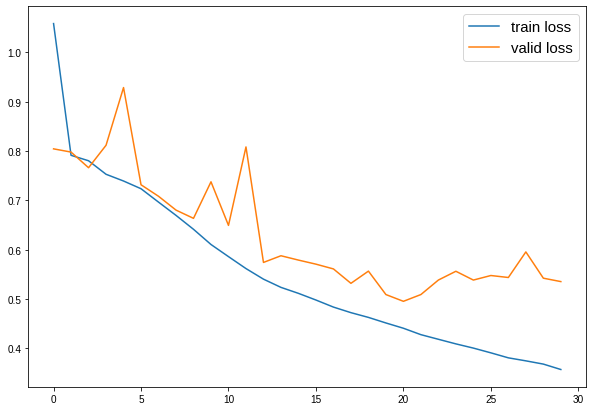

In [15]:
plt.figure(figsize=(10,7))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='valid loss')
plt.legend(fontsize=15)
plt.style.use("seaborn")
plt.show()

In [16]:
from tensorflow.keras.preprocessing.image import array_to_img

def display_mask(i):
    """Quick utility to display a model's prediction."""
    
    display_sample = val_preds[i].to('cpu')
    display_sample = display_sample.numpy()
    
    mask = np.argmax(display_sample, axis=0)
    mask = np.expand_dims(mask, axis=-1)    
    
    img = array_to_img(mask)
#     img = img.rotate(angle=270)
    img = PIL.ImageOps.autocontrast(img)
    
    display(img)

Image idx : 0
Input Image idx : 0


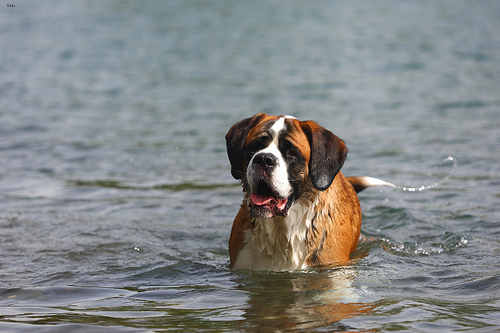

GT masked Image idx : 0


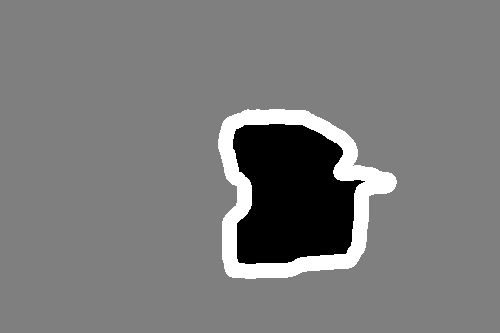

Predicted masked Image idx : 0


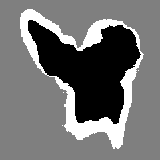

Image idx : 1
Input Image idx : 1


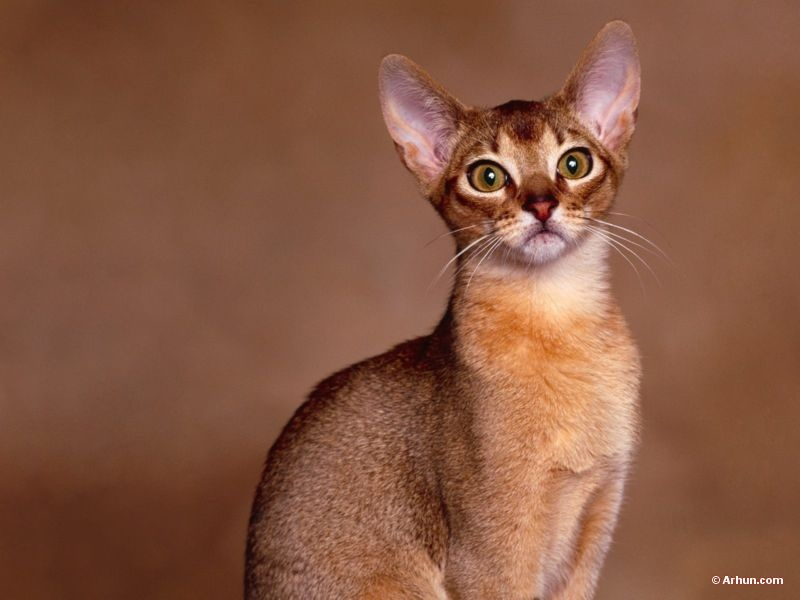

GT masked Image idx : 1


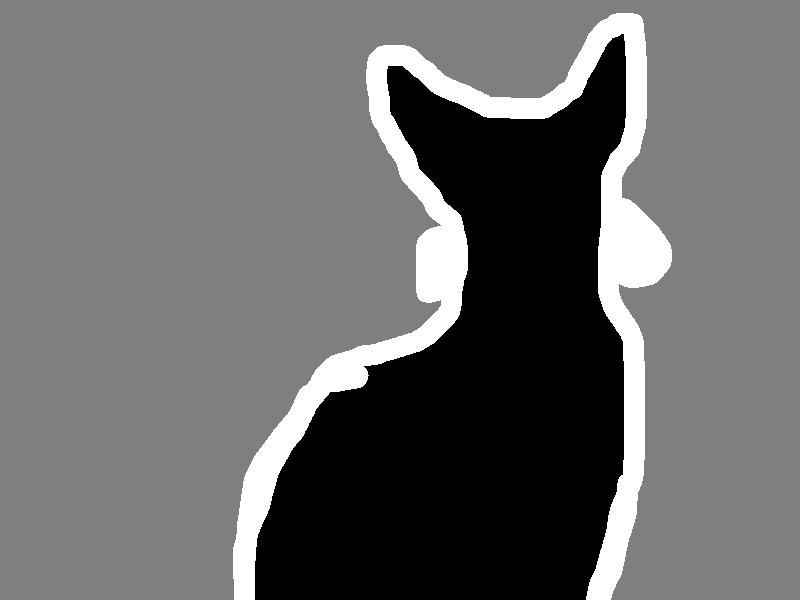

Predicted masked Image idx : 1


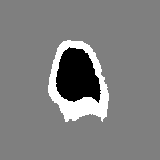

Image idx : 2
Input Image idx : 2


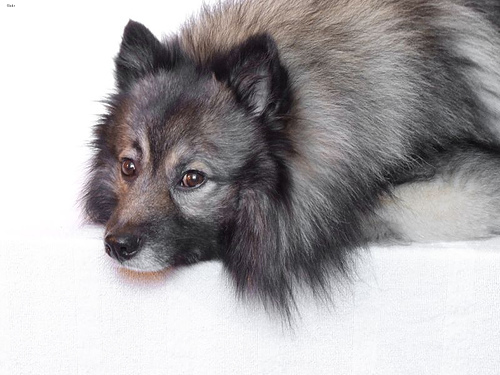

GT masked Image idx : 2


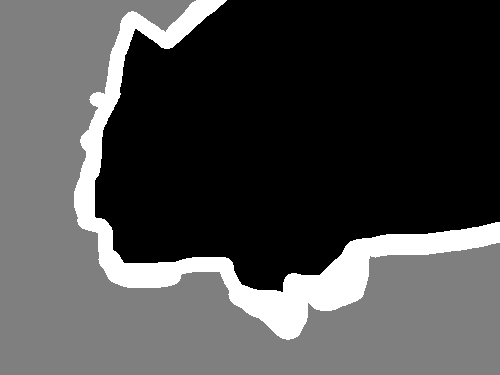

Predicted masked Image idx : 2


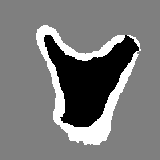

Image idx : 3
Input Image idx : 3


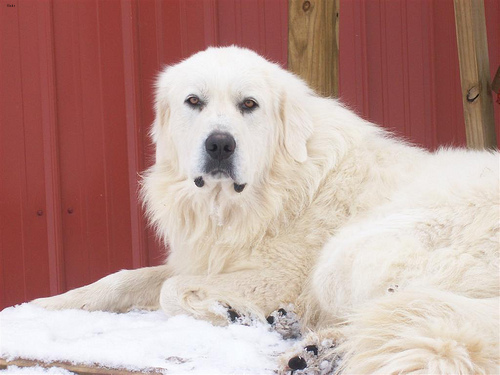

GT masked Image idx : 3


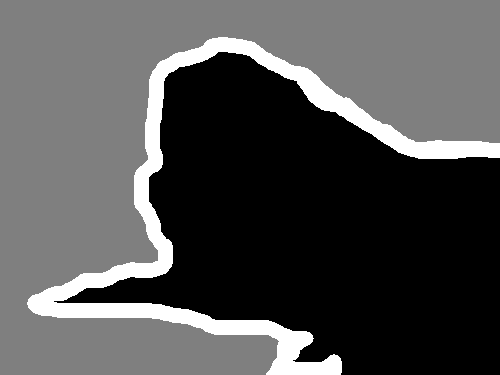

Predicted masked Image idx : 3


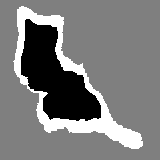

Image idx : 4
Input Image idx : 4


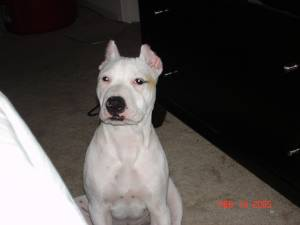

GT masked Image idx : 4


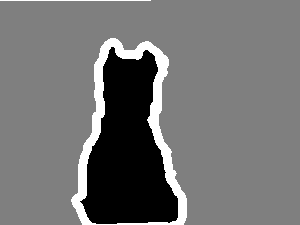

Predicted masked Image idx : 4


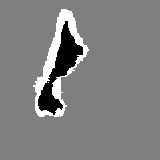

Image idx : 5
Input Image idx : 5


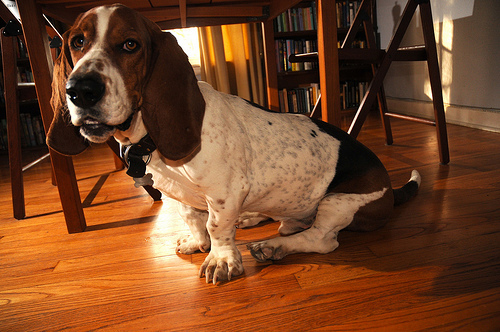

GT masked Image idx : 5


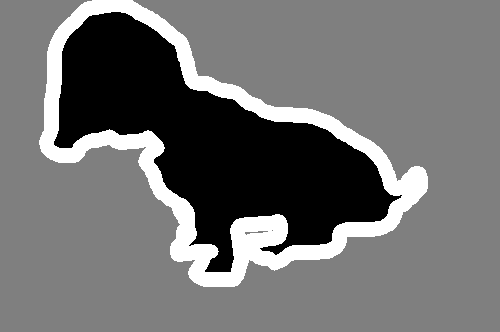

Predicted masked Image idx : 5


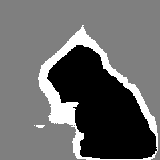

Image idx : 6
Input Image idx : 6


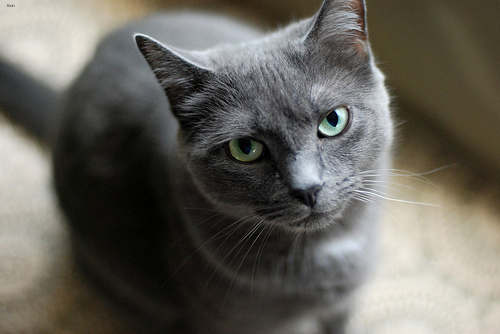

GT masked Image idx : 6


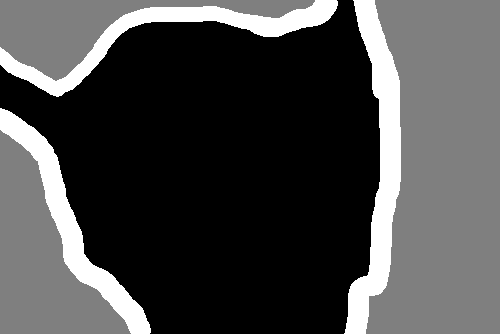

Predicted masked Image idx : 6


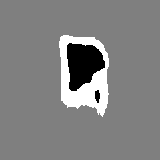

Image idx : 7
Input Image idx : 7


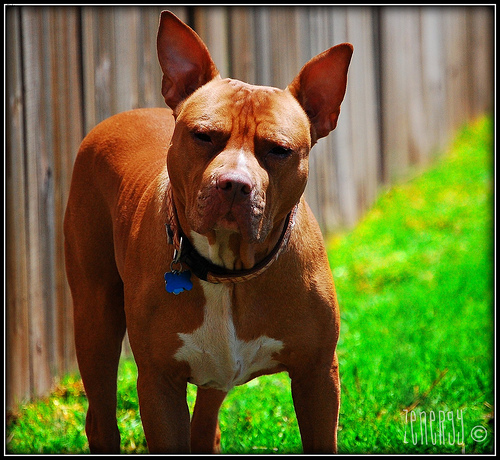

GT masked Image idx : 7


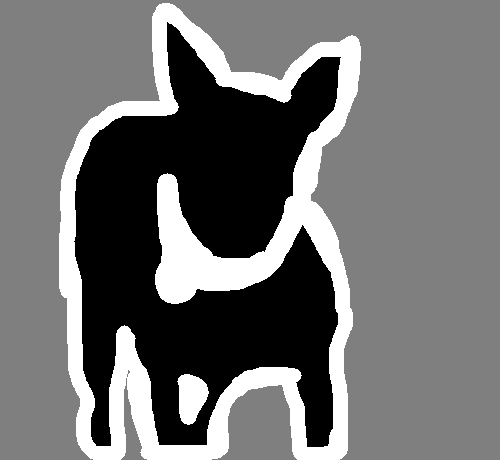

Predicted masked Image idx : 7


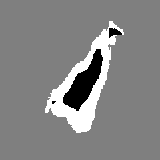

Image idx : 8
Input Image idx : 8


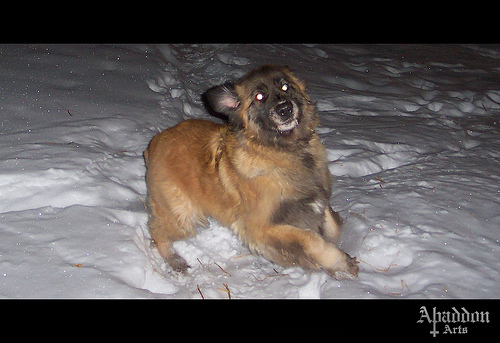

GT masked Image idx : 8


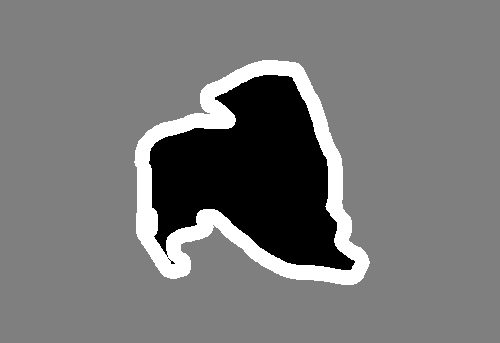

Predicted masked Image idx : 8


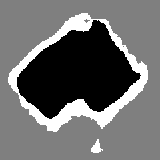

Image idx : 9
Input Image idx : 9


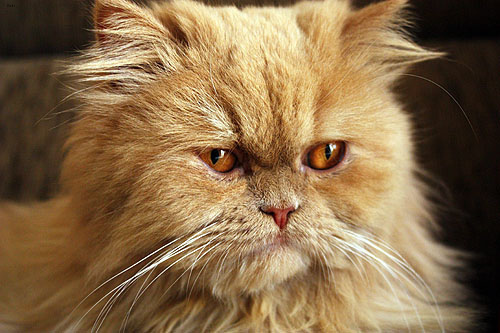

GT masked Image idx : 9


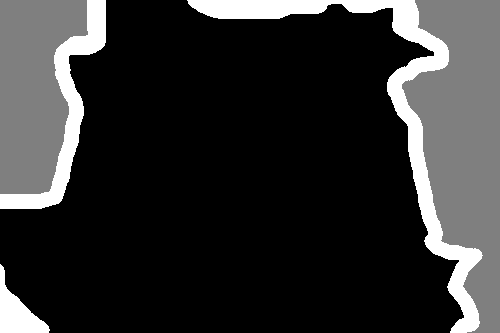

Predicted masked Image idx : 9


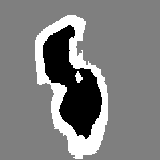

Image idx : 10
Input Image idx : 10


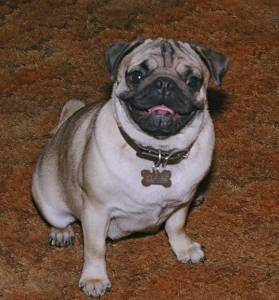

GT masked Image idx : 10


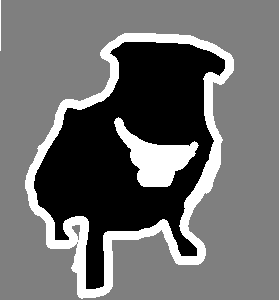

Predicted masked Image idx : 10


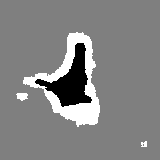

In [17]:
for i in range(11):
    print("==========================================================")
    print(f"Image idx : {i}")
    # Display input image
    print(f"Input Image idx : {i}")
    display(Image(filename=val_input_img_paths[i]))

    # Display ground-truth target mask
    print(f"GT masked Image idx : {i}")
    img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
    display(img)

    # Display mask predicted by our model
    print(f"Predicted masked Image idx : {i}")
    display_mask(i)  # Note that the model only sees inputs at 150x150.
    print("==========================================================")

## U-Net ver.

In [18]:
# reference : https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py

""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [19]:
# reference : https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_model.py

""" Full assembly of the parts to form the complete network """

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [20]:
unet = UNet(n_channels=3, n_classes=num_classes)
trained_model, train_losses, val_losses, val_preds = train_val_net(unet, 
                                                                   device=device, 
                                                                   num_epochs=15, 
                                                                   train_dataloader=train_dataloader,
                                                                   val_dataloader=val_dataloader)

[EPOCH : 0] | train loss : 0.8025, val loss : 0.9319
[EPOCH : 1] | train loss : 0.7457, val loss : 0.8702
[EPOCH : 2] | train loss : 0.7255, val loss : 0.7394
[EPOCH : 3] | train loss : 0.7046, val loss : 0.7848
[EPOCH : 4] | train loss : 0.6727, val loss : 0.7289
[EPOCH : 5] | train loss : 0.6281, val loss : 0.8920
[EPOCH : 6] | train loss : 0.5869, val loss : 0.6728
[EPOCH : 7] | train loss : 0.5505, val loss : 0.5921
[EPOCH : 8] | train loss : 0.5206, val loss : 0.5521
[EPOCH : 9] | train loss : 0.4924, val loss : 0.5861
[EPOCH : 10] | train loss : 0.4673, val loss : 0.4782
[EPOCH : 11] | train loss : 0.4444, val loss : 0.5287
[EPOCH : 12] | train loss : 0.4245, val loss : 0.4732
[EPOCH : 13] | train loss : 0.4058, val loss : 0.4647
[EPOCH : 14] | train loss : 0.3871, val loss : 0.5064


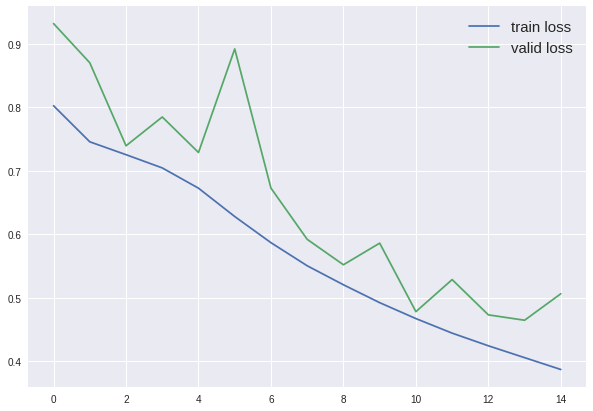

In [21]:
plt.figure(figsize=(10,7))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='valid loss')
plt.legend(fontsize=15)
plt.style.use("seaborn")
plt.show()

In [22]:
from tensorflow.keras.preprocessing.image import array_to_img

def display_mask(i):
    """Quick utility to display a model's prediction."""
    
    display_sample = val_preds[i].to('cpu')
    display_sample = display_sample.numpy()
    
    mask = np.argmax(display_sample, axis=0)
    mask = np.expand_dims(mask, axis=-1)    
    
    img = array_to_img(mask)
    img = img.rotate(angle=90)
    img = PIL.ImageOps.autocontrast(img)
    
    display(img)

Image idx : 0
Input Image idx : 0


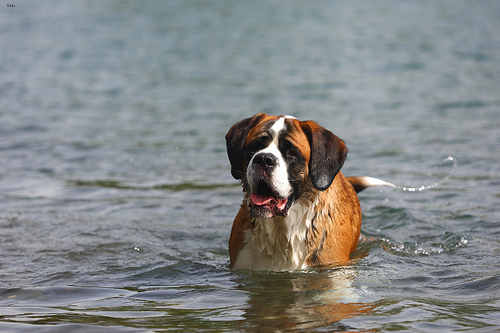

GT masked Image idx : 0


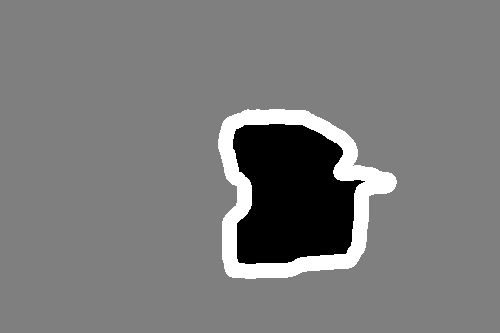

Predicted masked Image idx : 0


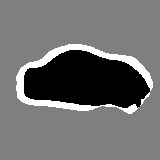

Image idx : 1
Input Image idx : 1


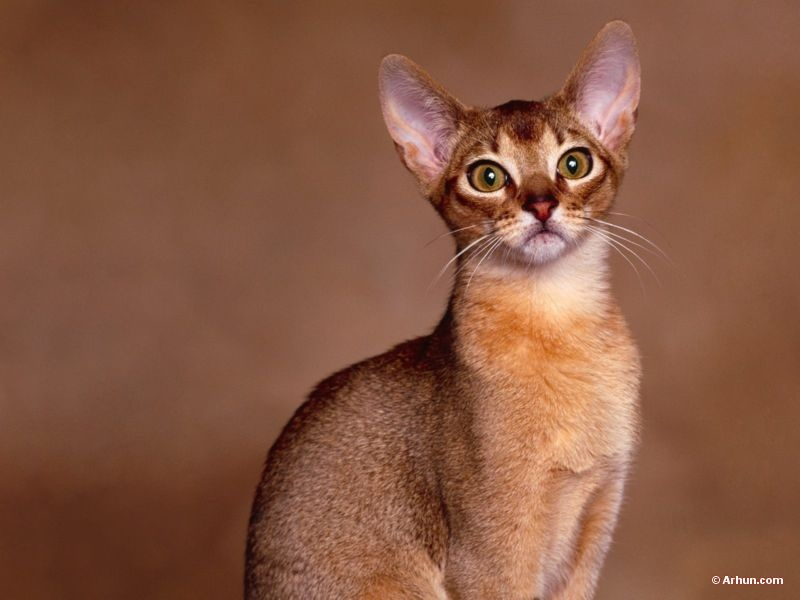

GT masked Image idx : 1


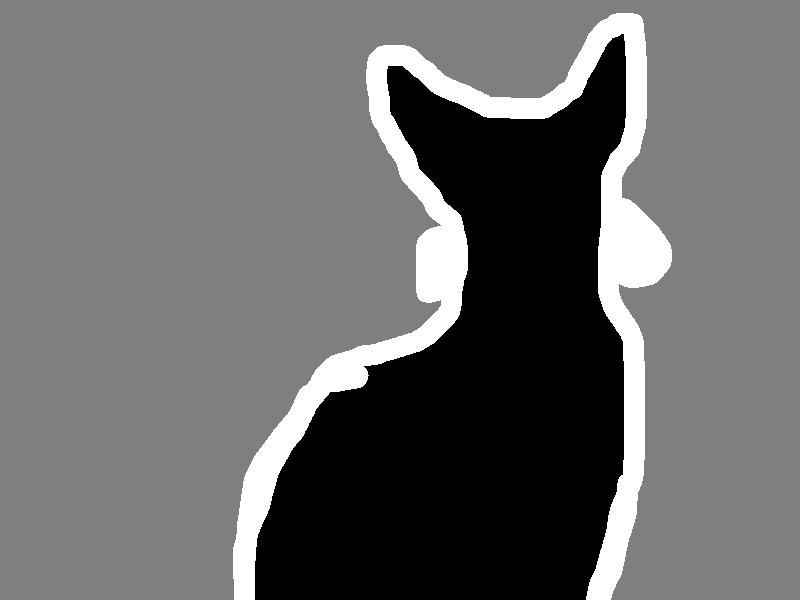

Predicted masked Image idx : 1


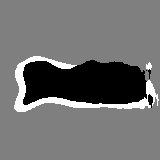

Image idx : 2
Input Image idx : 2


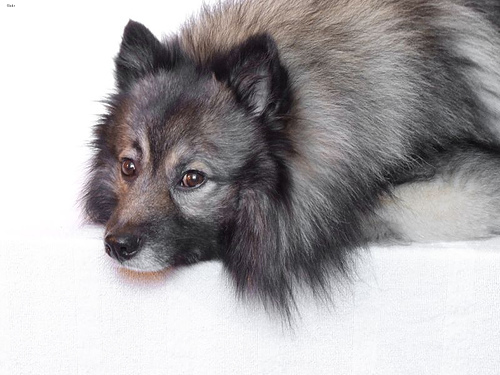

GT masked Image idx : 2


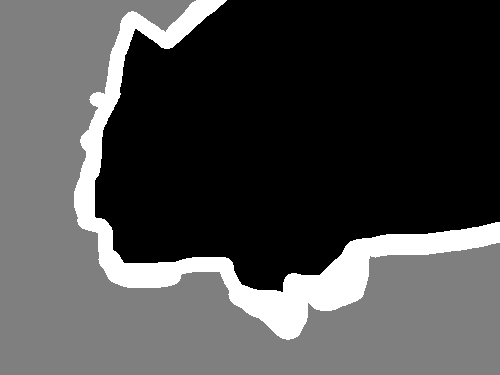

Predicted masked Image idx : 2


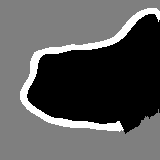

Image idx : 3
Input Image idx : 3


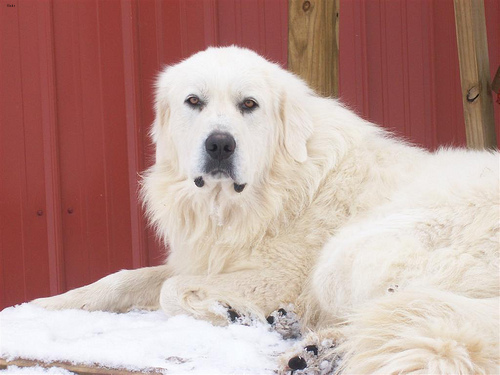

GT masked Image idx : 3


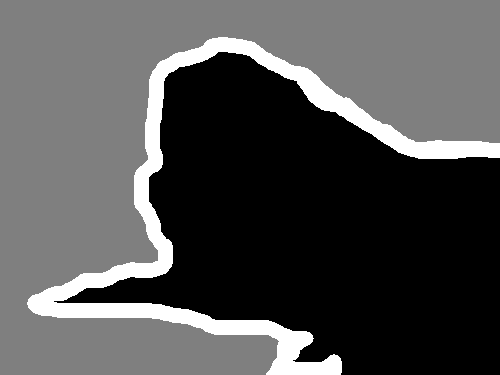

Predicted masked Image idx : 3


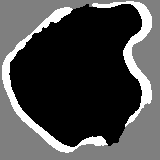

Image idx : 4
Input Image idx : 4


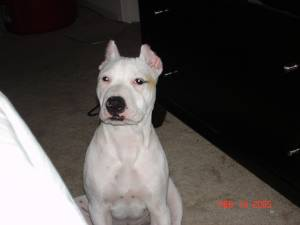

GT masked Image idx : 4


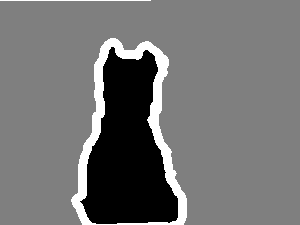

Predicted masked Image idx : 4


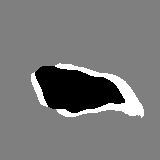

Image idx : 5
Input Image idx : 5


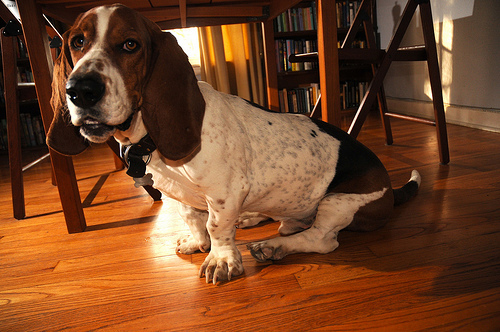

GT masked Image idx : 5


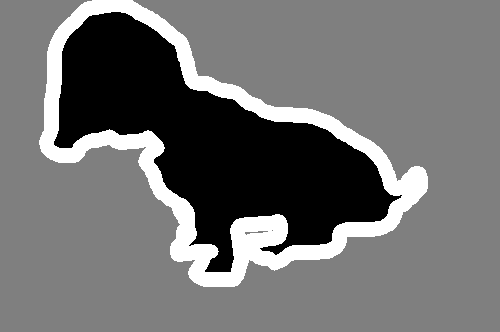

Predicted masked Image idx : 5


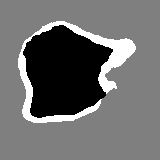

Image idx : 6
Input Image idx : 6


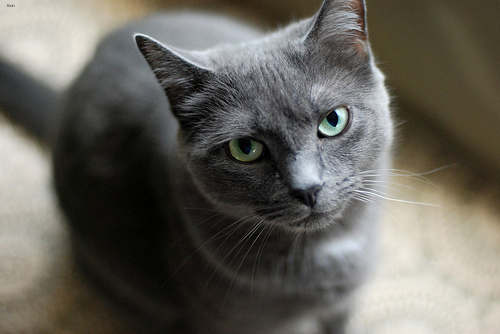

GT masked Image idx : 6


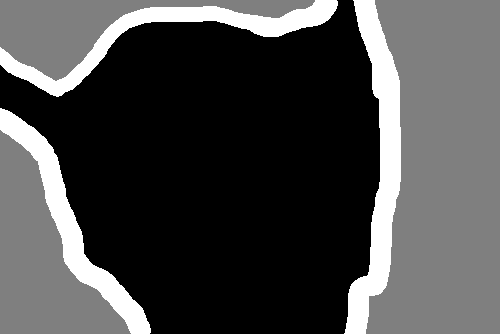

Predicted masked Image idx : 6


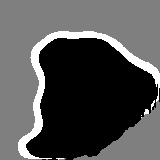

Image idx : 7
Input Image idx : 7


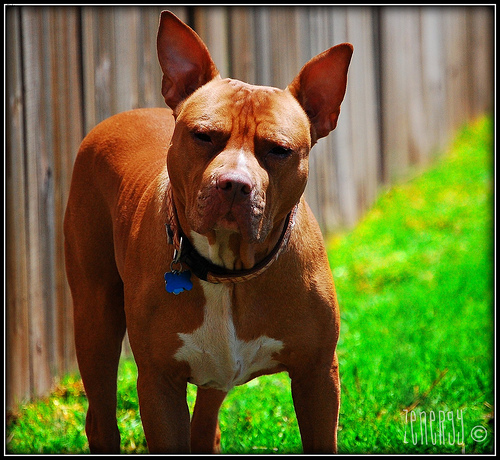

GT masked Image idx : 7


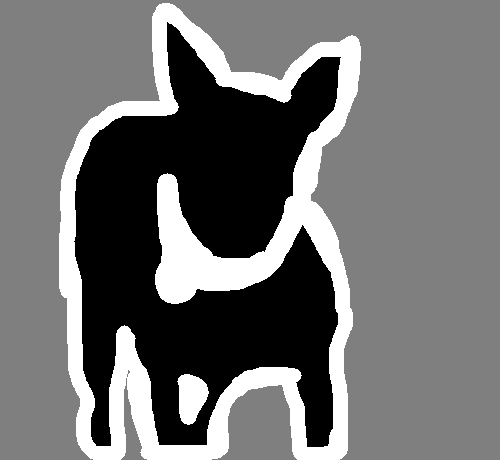

Predicted masked Image idx : 7


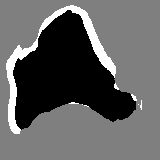

Image idx : 8
Input Image idx : 8


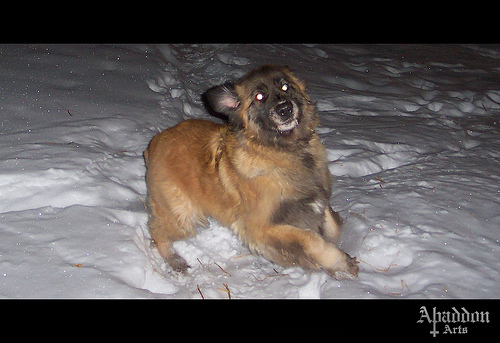

GT masked Image idx : 8


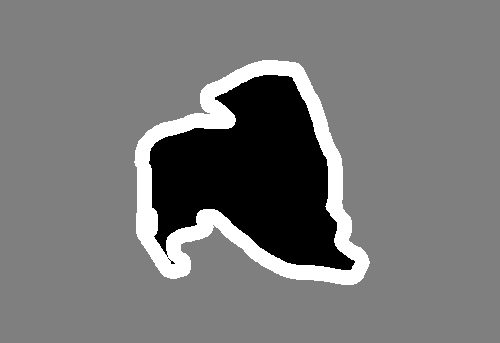

Predicted masked Image idx : 8


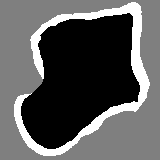

Image idx : 9
Input Image idx : 9


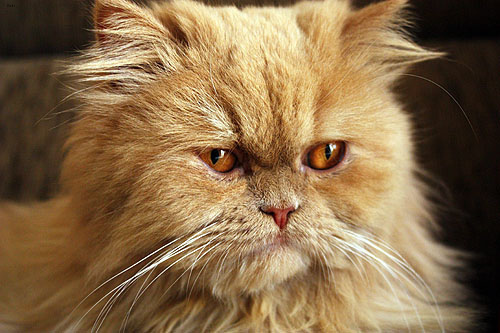

GT masked Image idx : 9


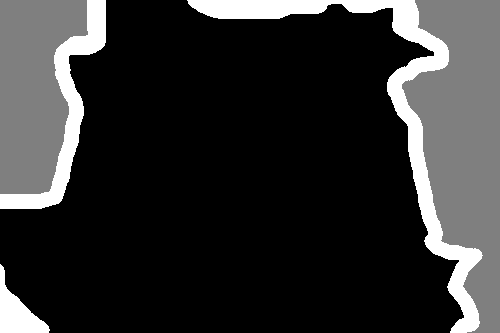

Predicted masked Image idx : 9


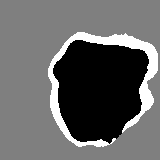

Image idx : 10
Input Image idx : 10


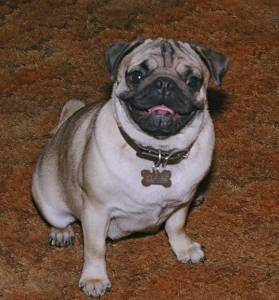

GT masked Image idx : 10


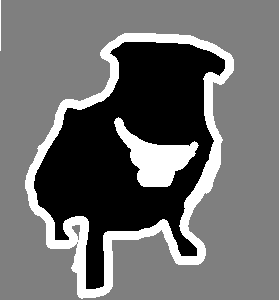

Predicted masked Image idx : 10


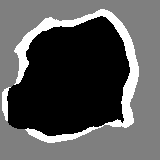

In [23]:
for i in range(11):
    print("==========================================================")
    print(f"Image idx : {i}")
    # Display input image
    print(f"Input Image idx : {i}")
    display(Image(filename=val_input_img_paths[i]))

    # Display ground-truth target mask
    print(f"GT masked Image idx : {i}")
    img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
    display(img)

    # Display mask predicted by our model
    print(f"Predicted masked Image idx : {i}")
    display_mask(i)  # Note that the model only sees inputs at 150x150.
    print("==========================================================")

## Supplement

**pytorch model 구조 summary & 시각화**

- reference 1 : https://lynnshin.tistory.com/54
    - torchsummary, torch_model_summary, torchinfo
- reference 2 : https://lynnshin.tistory.com/55
    - torchviz

In [24]:
print(unet_x)

UNet_Xception(
  (entry): Entry(
    (entry): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): Down_DoubleConv(
        (down_double_conv): Sequential(
          (0): ReLU(inplace=True)
          (1): SeparableConv2d(
            (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (pointwise): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
          (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): ReLU(inplace=True)
          (4): SeparableConv2d(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (pointwise): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1

In [25]:
import torchsummary
import pytorch_model_summary

torchsummary.summary(unet_x, (3,160,160))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 80, 80]             896
       BatchNorm2d-2           [-1, 32, 80, 80]              64
              ReLU-3           [-1, 32, 80, 80]               0
             Entry-4           [-1, 32, 80, 80]               0
              ReLU-5           [-1, 32, 80, 80]               0
            Conv2d-6           [-1, 32, 80, 80]             288
            Conv2d-7           [-1, 64, 80, 80]           2,048
   SeparableConv2d-8           [-1, 64, 80, 80]               0
       BatchNorm2d-9           [-1, 64, 80, 80]             128
             ReLU-10           [-1, 64, 80, 80]               0
           Conv2d-11           [-1, 64, 80, 80]             576
           Conv2d-12           [-1, 64, 80, 80]           4,096
  SeparableConv2d-13           [-1, 64, 80, 80]               0
      BatchNorm2d-14           [-1, 64,

In [26]:
print(pytorch_model_summary.summary(unet, torch.zeros(1, 3, 160, 160).to(device), show_input=False))

-------------------------------------------------------------------------
      Layer (type)          Output Shape         Param #     Tr. Param #
      DoubleConv-1     [1, 64, 160, 160]          38,976          38,976
            Down-2      [1, 128, 80, 80]         221,952         221,952
            Down-3      [1, 256, 40, 40]         886,272         886,272
            Down-4      [1, 512, 20, 20]       3,542,016       3,542,016
            Down-5      [1, 512, 10, 10]       4,721,664       4,721,664
              Up-6      [1, 256, 20, 20]       5,900,544       5,900,544
              Up-7      [1, 128, 40, 40]       1,475,712       1,475,712
              Up-8       [1, 64, 80, 80]         369,216         369,216
              Up-9     [1, 64, 160, 160]         110,976         110,976
        OutConv-10      [1, 3, 160, 160]             195             195
Total params: 17,267,523
Trainable params: 17,267,523
Non-trainable params: 0
---------------------------------------------

In [27]:
from torchinfo import summary

batch_size = batch_size
summary(unet_x, input_size=(batch_size, 3, 160, 160))

Layer (type:depth-idx)                             Output Shape              Param #
UNet_Xception                                      --                        --
├─Entry: 1-1                                       [32, 32, 80, 80]          --
│    └─Sequential: 2-1                             [32, 32, 80, 80]          --
│    │    └─Conv2d: 3-1                            [32, 32, 80, 80]          896
│    │    └─BatchNorm2d: 3-2                       [32, 32, 80, 80]          64
│    │    └─ReLU: 3-3                              [32, 32, 80, 80]          --
├─Down: 1-2                                        [32, 64, 40, 40]          --
│    └─Sequential: 2-2                             [32, 64, 40, 40]          --
│    │    └─Down_DoubleConv: 3-4                   [32, 64, 80, 80]          7,264
│    │    └─MaxPool2d: 3-5                         [32, 64, 40, 40]          --
├─Down: 1-3                                        [32, 128, 20, 20]         --
│    └─Sequential: 2-3         

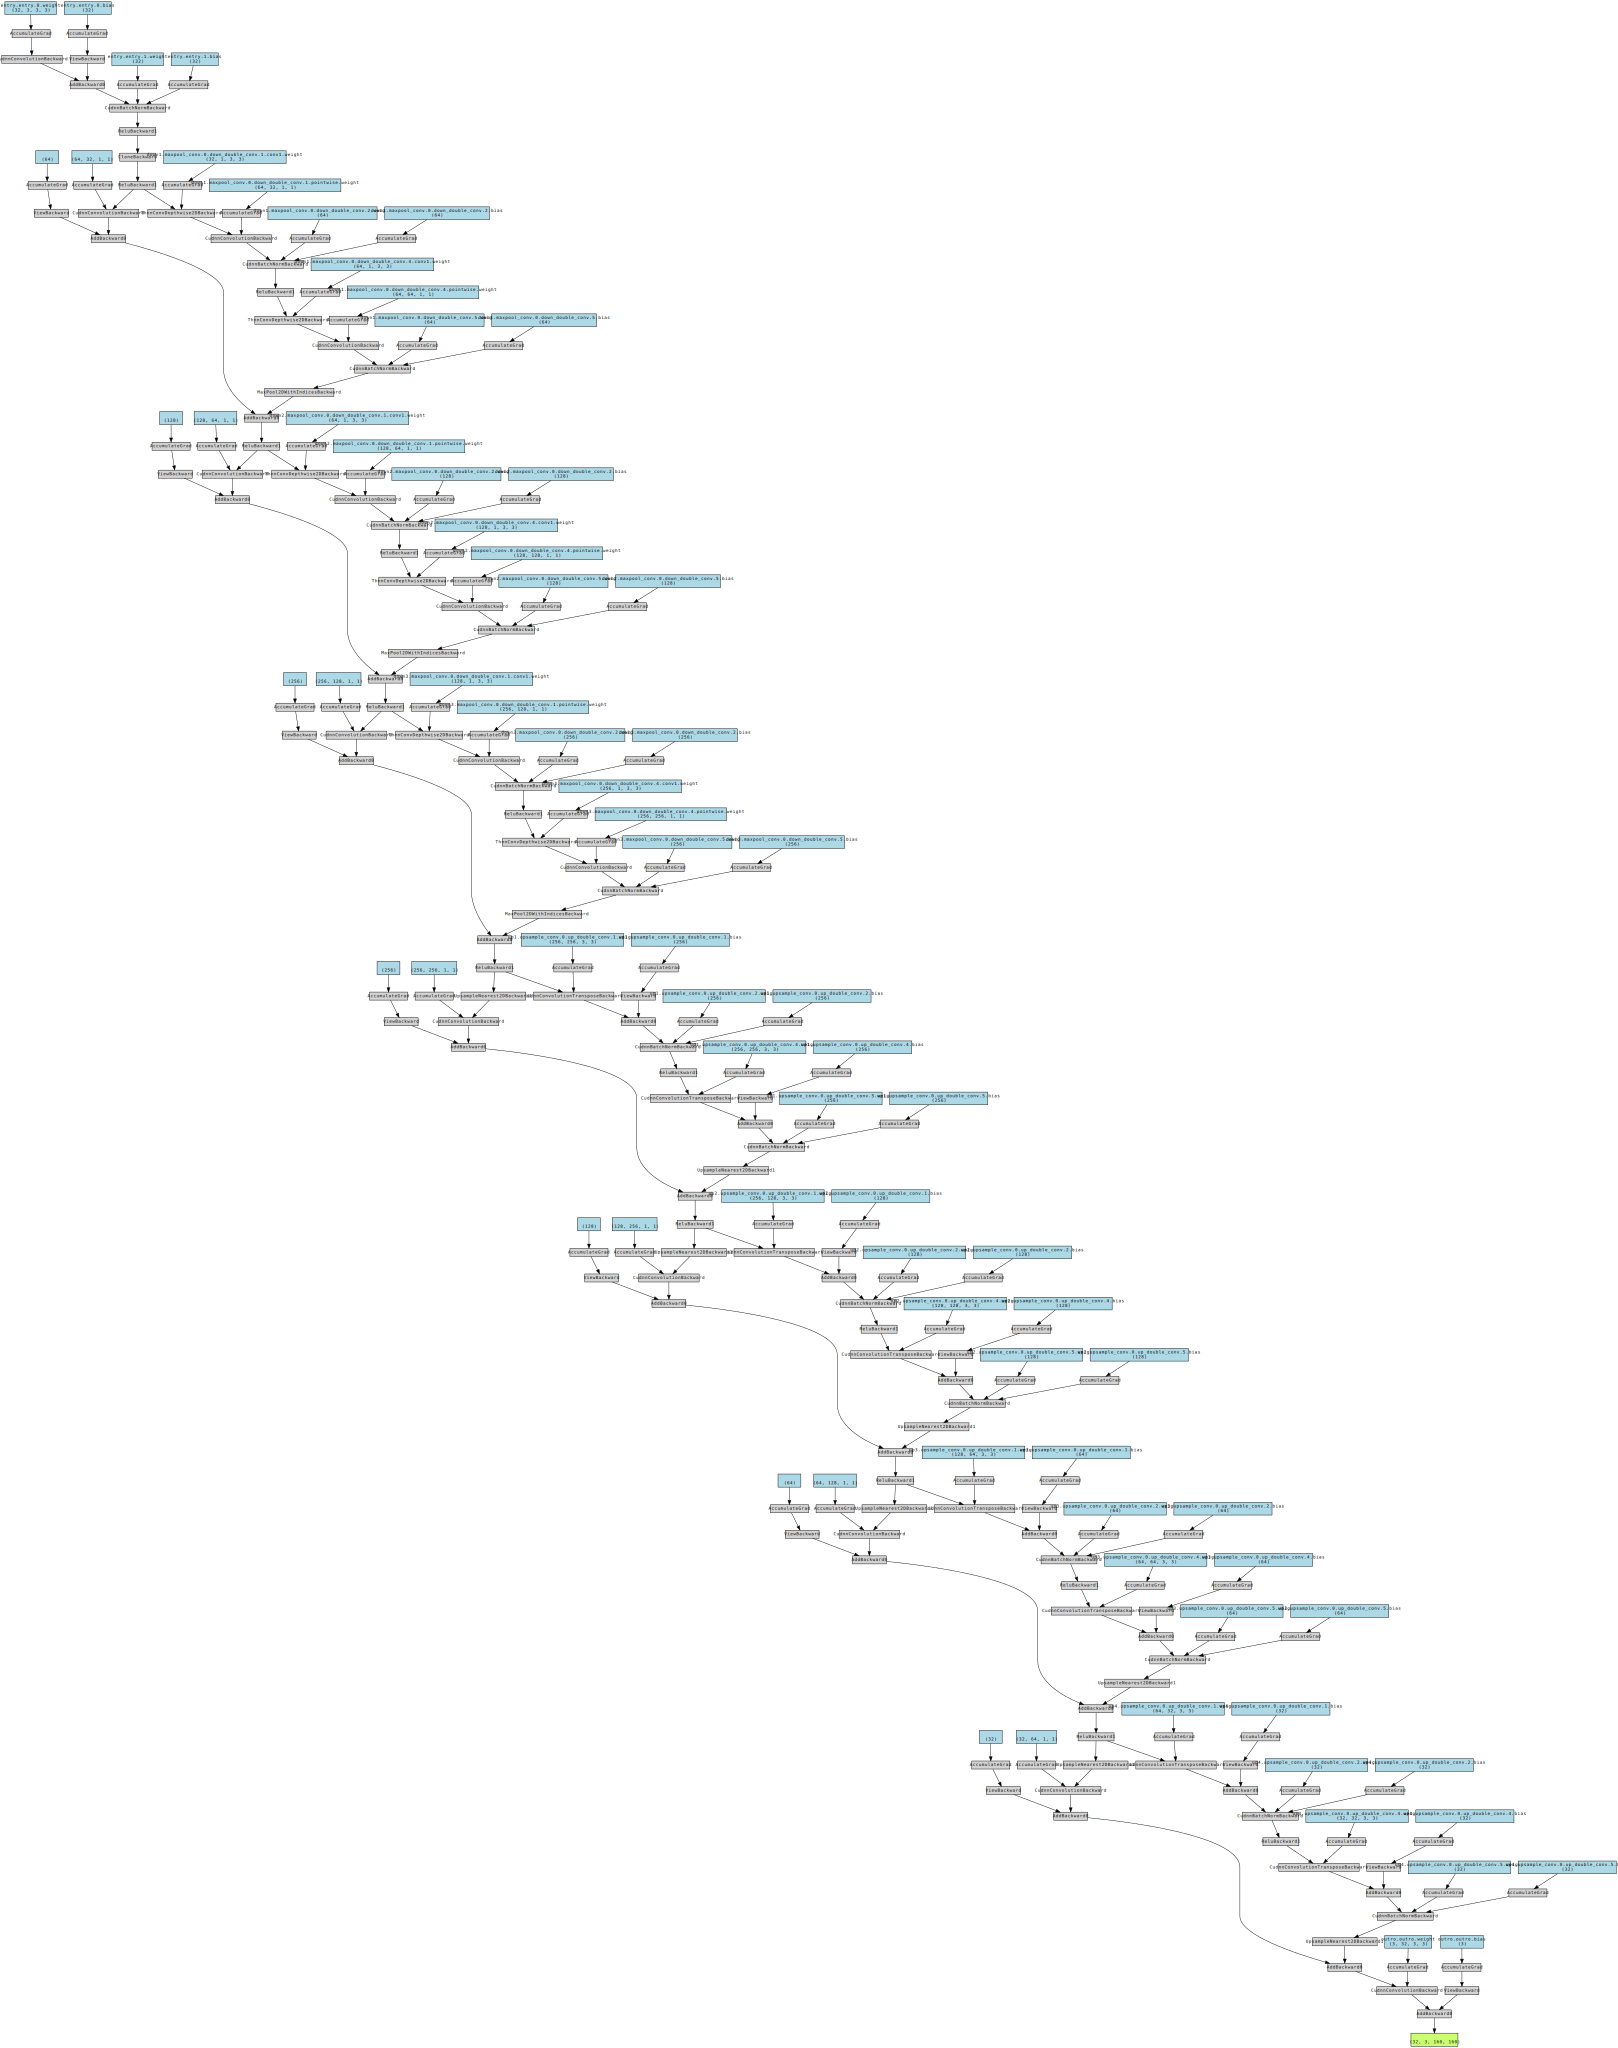

In [28]:
from torchviz import make_dot

tmp_input = torch.zeros(batch_size, 3, 160, 160, device=device)
make_dot(unet_x(tmp_input).to(device), params=dict(list(unet_x.named_parameters())))

In [29]:
make_dot(unet_x(tmp_input).to(device),
         params = dict(list(unet_x.named_parameters()))
        ).render("unet_x_torchviz", format='png')

'unet_x_torchviz.png'